# Import libraries

In [1]:
# for Kaggle
# !pip install -U lightautoml

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
# edited by Mayur

import re
import gc
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tqdm_notebook

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    downcast_dtypes
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

# Load necessary files

In [3]:
items = pd.read_csv("items.csv.zip")
item_categories = pd.read_csv("item_categories.csv")
sales_train = pd.read_csv("sales_train.csv.zip", parse_dates=['date'])
shops = pd.read_csv("shops.csv")
sales_test = pd.read_csv("test.csv.zip")
submission = pd.read_csv("sample_submission.csv.zip")

# for Kaggle

# PATH = '../input/competitive-data-science-predict-future-sales'

# items           = pd.read_csv(os.path.join(PATH,'items.csv'))
# item_categories = pd.read_csv(os.path.join(PATH,'item_categories.csv'))
# sales_train     = pd.read_csv(os.path.join(PATH,'sales_train.csv'), parse_dates=['date'])
# shops           = pd.read_csv(os.path.join(PATH,'shops.csv'))
# sales_test      = pd.read_csv(os.path.join(PATH,'test.csv'))
# submission      = pd.read_csv(os.path.join(PATH,'sample_submission.csv'))

# drop duplicates
sales_train.drop_duplicates(inplace=True)

# add date_block_num feature to test df, set it value to 34
sales_test['date_block_num'] = 34
sales_test.date_block_num = sales_test.date_block_num.astype(np.int32)

# Research dataset

In [4]:
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1.0
1,2013-03-01,0,25,2552,899.00,1.0
2,2013-05-01,0,25,2552,899.00,-1.0
3,2013-06-01,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


Does train dataset contains zeros?

In [5]:
sales_train.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

Research features

# item_cnt_day

(array([2.934458e+06, 1.204000e+03, 1.110000e+02, 3.100000e+01,
        1.100000e+01, 5.000000e+00, 4.000000e+00, 4.000000e+00,
        0.000000e+00, 8.000000e+00, 2.000000e+00, 1.000000e+00,
        2.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 1.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ -22.   ,   32.775,   87.55 ,  142.325,  197.1  ,  251.875,
         306.65 ,  361.425,  416.2  ,  470.975,  525.75 ,  580.525,
         635.3  ,  690.075,  744.85 ,  799.625,  854.4  ,  909.175,
         963.95 , 1018.725, 1073.5  , 1128.275, 1183.05 , 1237.825,
        1292.6  , 1347.375, 1402.15 , 1456.925, 1511.7  , 1566.475,
        1621.25 , 

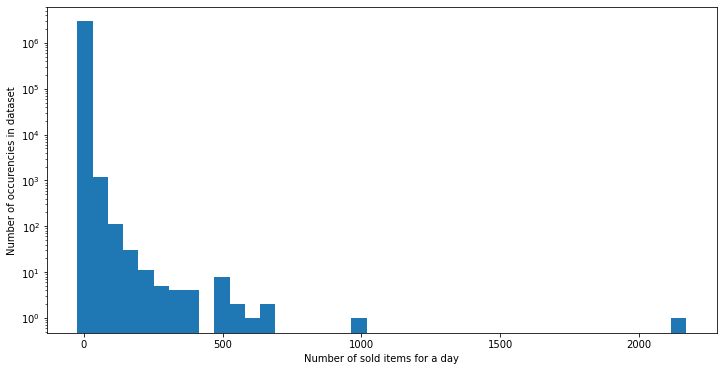

In [6]:
plt.figure(figsize=(12,6))
plt.xlabel('Number of sold items for a day')
plt.ylabel('Number of occurencies in dataset')
plt.yscale('log')
plt.hist(sales_train.item_cnt_day, bins=40)

In [7]:
sales_train.item_cnt_day.describe()

count    2.935843e+06
mean     1.242641e+00
std      2.618837e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

Group number of sold items by date_block and plot.

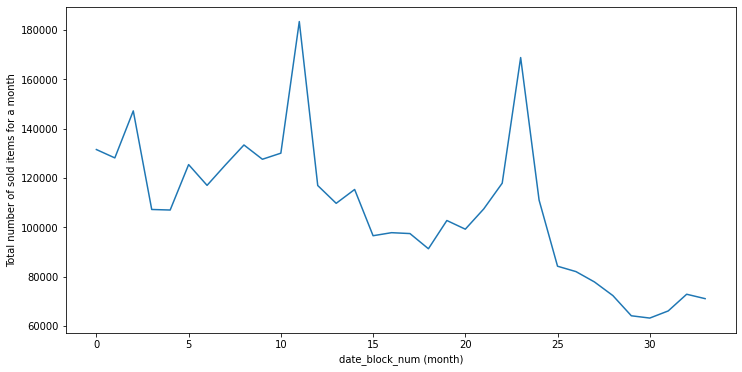

In [8]:
plt.figure(figsize=(12,6))
plt.xlabel('date_block_num (month)')
plt.ylabel('Total number of sold items for a month')
plt.plot(sales_train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'}).reset_index()['item_cnt_day'])

There is an obvious trend with peaks at New Year holidays.

# item_price

Distribution of items price and outliers

In [9]:
sales_train.item_price.describe()

count    2.935843e+06
mean     8.908535e+02
std      1.729801e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

<AxesSubplot:xlabel='item_price'>

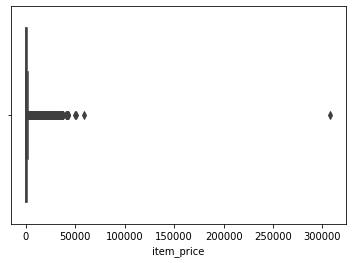

In [10]:
sns.boxplot(x='item_price', data=sales_train)

Majority of items has price lower than 5000.

# date_block_num

In [11]:
sales_train.date_block_num.describe()

count    2.935843e+06
mean     1.456991e+01
std      9.422992e+00
min      0.000000e+00
25%      7.000000e+00
50%      1.400000e+01
75%      2.300000e+01
max      3.300000e+01
Name: date_block_num, dtype: float64

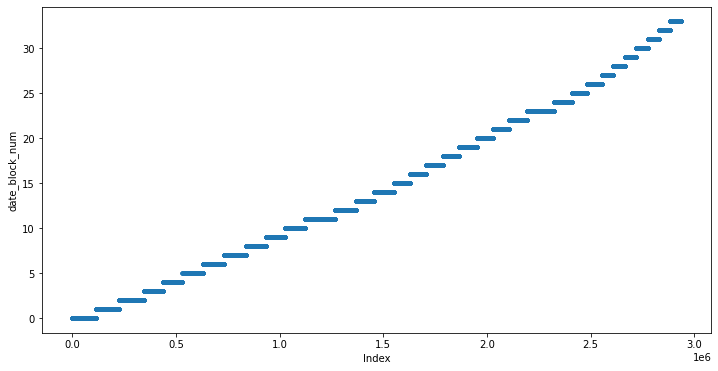

In [12]:
plt.figure(figsize=(12,6))
plt.xlabel('Index')
plt.ylabel('date_block_num')
plt.plot(sales_train.date_block_num, '.')

We can suppose, that dataset was built by concatenating of smaller datasets for each date block

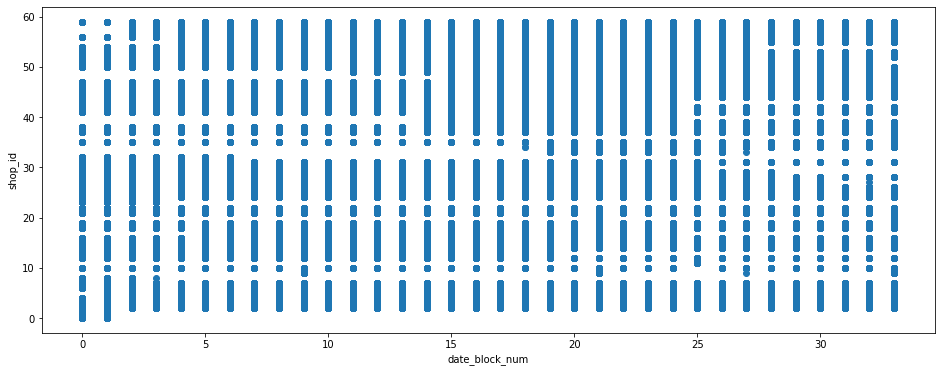

In [13]:
plt.figure(figsize=(16, 6))
plt.xlabel('date_block_num')
plt.ylabel('shop_id')
plt.scatter(sales_train.date_block_num, sales_train.shop_id)

# shop_id

What shops are presented in train set but aren't presented in the test set?

<AxesSubplot:>

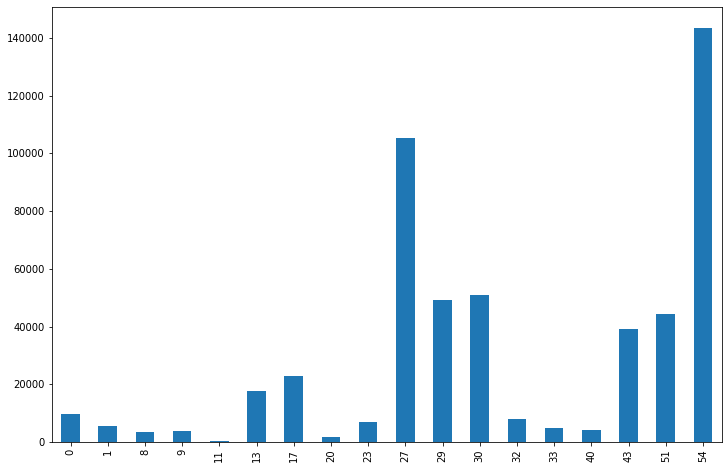

In [14]:
missed_ind = sorted([c for c in sales_train.shop_id.unique() if c not in sales_test.shop_id.unique()])
sales_train.shop_id.value_counts().sort_index().iloc[missed_ind].plot.bar(figsize=(12, 8))

Me may don't need shops with id's 8, 9, 11, 20 and 40. 

We can see strong vertical pattern. This means that data wasn't shaffled for shops. We also can see, that data for some shops and date blocks are missing.

# Fix wrong shops id's

Some shop names look similar

In [15]:
print(shops.loc[shops.shop_id.isin([0, 57]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([1, 58]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([10, 11]), 'shop_name'])
print(shops.loc[shops.shop_id.isin([39, 40]), 'shop_name'])

0     !Якутск Орджоникидзе, 56 фран
57          Якутск Орджоникидзе, 56
Name: shop_name, dtype: object
1     !Якутск ТЦ "Центральный" фран
58          Якутск ТЦ "Центральный"
Name: shop_name, dtype: object
10    Жуковский ул. Чкалова 39м?
11    Жуковский ул. Чкалова 39м²
Name: shop_name, dtype: object
39              РостовНаДону ТРК "Мегацентр Горизонт"
40    РостовНаДону ТРК "Мегацентр Горизонт" Островной
Name: shop_name, dtype: object


Let's correct this

In [16]:
sales_train.loc[sales_train.shop_id == 0, 'shop_id'] = 57
sales_test.loc[sales_test.shop_id == 0, 'shop_id'] = 57

sales_train.loc[sales_train.shop_id == 1, 'shop_id'] = 58
sales_test.loc[sales_test.shop_id == 1, 'shop_id'] = 58

sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10 # shop_id 11 isn't presented in the test set
sales_test.loc[sales_test.shop_id == 11, 'shop_id'] = 10

sales_train.loc[sales_train.shop_id == 40, 'shop_id'] = 39
sales_test.loc[sales_test.shop_id == 40, 'shop_id'] = 39

# Fix wrong prices

Some of prices may be wrong. Let's find them. At first we look for prices with big difference between min and max price for each item and find the most frequent normal prices for them.

In [17]:
# for each item get price with mode value > 5
def amode(col):
    i = 0
    res = 0
    count = col.value_counts().index
    while res <= 5 and i < len(count):
        res = count[i]
        i += 1
    return res

def alast(col):
    return res
    
# group train dataset by prices, aggregate by price mode
item_prices = sales_train[['item_id', 'item_price']].groupby('item_id').agg({'item_price': [np.min, 
                                                                                            np.max, 
                                                                                            amode]})
# add feature for difference between min and max prices
item_prices['price_diff'] = abs(item_prices.item_price.amax/item_prices.item_price.amin)

# get all prices with the difference between min and max prices more than 15 and min price less than 5
# save indexes of these prices
wrong_prices = item_prices[(item_prices.item_price.amin <= 5) & 
                           (item_prices.price_diff >= 15)].sort_values('price_diff', ascending=False)

wrong_prices.head()

item_price                    price_diff
              amin    amax   amode              
item_id                                         
11865         0.07   729.0   329.0  10414.285714
11857         0.10   729.0   319.0   7290.000000
11864         0.07   469.0   269.0   6700.000000
1836          0.50  2599.0  1999.0   5198.000000
1837          0.50  2599.0  1999.0   5198.000000

Fix wrong prices

In [18]:
for i_id in list(wrong_prices.index):
    sales_train.loc[(sales_train.item_id == i_id) & 
                    (sales_train.item_price <= 5), 'item_price'] = wrong_prices.loc[i_id, 'item_price'].amode
    
del wrong_prices
gc.collect()

79

# Fix wrong dates

Let's add year, month and day features and check if they are correct.

In [19]:
sales_train.date = pd.to_datetime(sales_train.date, format='%Y-%m-%d')
sales_train['year'] = sales_train.date.dt.year
sales_train['month'] = sales_train.date.dt.month
sales_train['day'] = sales_train.date.dt.day
sales_train[(sales_train.month == 1) & (sales_train.year == 2013) & sales_train.date_block_num > 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
115846,2013-01-02,1,50,3705,1499.00,2.0,2013,1,2
115861,2013-01-02,1,50,3745,799.00,1.0,2013,1,2
115946,2013-01-02,1,50,5262,719.52,1.0,2013,1,2
115979,2013-01-02,1,50,5272,399.56,1.0,2013,1,2
116070,2013-01-02,1,50,4886,899.00,1.0,2013,1,2
...,...,...,...,...,...,...,...,...,...
1267281,2013-01-12,11,46,4477,899.00,1.0,2013,1,12
1267430,2013-01-12,11,46,5620,590.00,1.0,2013,1,12
1267455,2013-01-12,11,46,5643,2490.00,1.0,2013,1,12
1267552,2013-01-12,11,46,5672,2590.00,1.0,2013,1,12


As we can see, some date values do not correspond to date_block_num values. Further investigation lead to conclusion, that this is because date values are wrong: day and month are confused with each other. Let's fix that.

In [20]:
def add_month(col):
    return int(divmod(col, 12)[1] + 1)

sales_train['month_from_date_block'] = sales_train.date_block_num.apply(add_month)

date_index = sales_train.loc[sales_train.month != sales_train.month_from_date_block].index

day = sales_train.loc[date_index, 'day']
month = sales_train.loc[date_index, 'month']

sales_train.loc[date_index, 'day'] = month
sales_train.loc[date_index, 'month'] = day

# fix date with correct month and year values
sales_train.date = sales_train.year.astype(str) + '-' + sales_train.month.astype(str) + '-' + sales_train.day.astype(str)
sales_train.date = pd.to_datetime(sales_train.date, format='%Y-%m-%d')

sales_train.drop(['month_from_date_block'], axis=1, inplace=True)

# Add month of last sale and how long time ago the previous sale was 

In [21]:
%%time

# sort rows of df by date
sales_train = sales_train.sort_values('date').reset_index(drop=True)

# dictionary for storing of the last date_block for current item in current shop
ids_dict = dict()

def get_prev_sales(row):
    shop_id, item_id, date_block_num = row.shop_id, row.item_id, row.date_block_num
    if (shop_id, item_id) in ids_dict:
        res = ids_dict[(shop_id, item_id)]
    else:
        res = np.nan
    ids_dict[(shop_id, item_id)] = date_block_num
    return res

   
sales_train['date_block_of_last_sale'] = sales_train.apply(get_prev_sales, axis=1)   
sales_train['last_saled_months_ago'] = sales_train.date_block_num - sales_train.date_block_of_last_sale

sales_test['date_block_of_last_sale'] = sales_test.apply(get_prev_sales, axis=1)   
sales_test['last_saled_months_ago'] = sales_test.date_block_num - sales_test.date_block_of_last_sale

sales_train.drop('date_block_of_last_sale', axis=1, inplace=True)
# sales_train.date_block_of_last_sale.fillna(0, inplace=True)
sales_train.last_saled_months_ago.fillna(0, inplace=True)

sales_test.drop('date_block_of_last_sale', axis=1, inplace=True)
# sales_test.date_block_of_last_sale.fillna(0, inplace=True)
sales_test.last_saled_months_ago.fillna(0, inplace=True)

CPU times: user 50.7 s, sys: 381 ms, total: 51 s
Wall time: 51 s


# Add first and last days of sale for each month

Group dataset by shop, item and date number.

# Group train dataset, investigate data distribution for train and test datasets.

In [22]:
sales_train_gr = sales_train.groupby(['date_block_num', 
                                      'shop_id', 'item_id'], as_index=False).agg({'item_price': 'mean', 
                                                                                  'item_cnt_day': 'sum'})

sales_train_gr.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

Let's investigate distribution of items and shops according to mean date block number.

Train dataset.

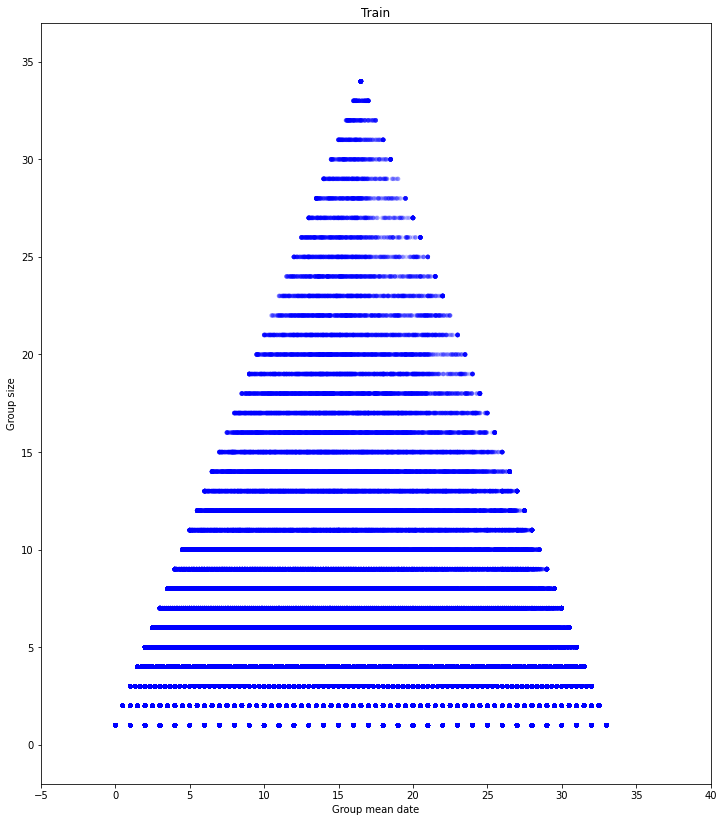

In [23]:
from matplotlib import pyplot as plt

g = sales_train_gr.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,14))
plt.scatter(g.date_block_num.mean(), g.size(), edgecolor = 'none', alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean date')
plt.ylabel('Group size')
plt.ylim(-2, 37)
plt.xlim(-5, 40)
plt.title('Train');

Test dataset

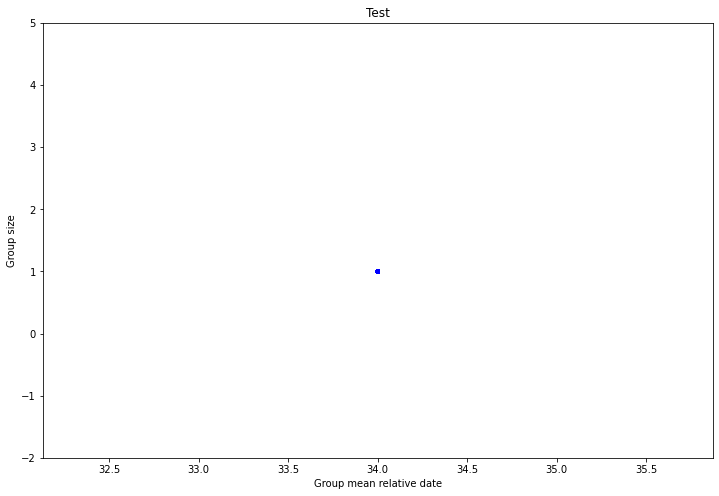

In [24]:
g = sales_test.groupby(['shop_id', 'item_id'])

plt.figure(figsize=(12,8))
plt.scatter(g.date_block_num.mean(),g.size(),edgecolor = 'none',alpha = 0.2, s=20, c='b')
plt.xlabel('Group mean relative date')
plt.ylabel('Group size')
plt.ylim(-2, 5)
plt.title('Test');

What does that mean? That mean that all groups in test dataset have size of one and labeled by 34th date block num, but that's not surprise for us.

But train dataset has groups with completely different sizes and completely different data. For groups in the top of our triangle we have information about all days, so, that's why their mean date is 16.5. For other groups we don't have full information, that's why their mean date becomes volatile.

Why does this happen? Let's investigate item_cnt_day feature in our dataset. 

In [25]:
sales_train.item_cnt_day.value_counts().sort_index().head(10)

-22.0          1
-16.0          1
-9.0           1
-6.0           2
-5.0           4
-4.0           3
-3.0          14
-2.0          78
-1.0        7252
 1.0     2629366
Name: item_cnt_day, dtype: int64

So, in the train dataset we find positive and negative values, but don't find zero. Our train dataset just doesn't include data with item_cnt_day equals to zero. So, we most add this combinations to our dataset and set item_cnt_month value for them to zero.

# Create all unique combinations of shop_id, item_id and date_block_num

In [26]:
%%time

from itertools import product

index_cols = ['date_block_num', 'shop_id', 'item_id']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[[block_num], cur_shops, cur_items])),dtype='int32'))

#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols, dtype=np.int32)

#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols, as_index=False).agg({'item_cnt_day': 'sum', 
                                                          'item_price': 'mean', 
#                                                           'date_block_of_last_sale': 'first', 
                                                          'last_saled_months_ago': 'first',
                                                          'day': ['first', 'last']
                                                         })

# rename columns in gb df
cols = list()
for c in gb.columns: 
    if c[0] == 'day':
        cols.append(c[1] + '_' + c[0])
    else:
        cols.append(c[0])
        
gb.columns = cols

#join aggregated data to the grid
sales_train2 = pd.merge(grid, gb, how='left', on=index_cols)

#sort the data
sales_train2.sort_values(index_cols, inplace=True)

# rename target column name
sales_train2.rename({'item_cnt_day': 'item_cnt_month'}, axis=1, inplace=True)

# reset index for new train dataset
sales_train2.reset_index(inplace=True, drop=True)

# flll NaN values
sales_train2.fillna(0, inplace=True)

# add first_day and last_day features to test df
sales_train_gr = sales_train2.groupby(['shop_id', 'item_id']).agg({'first_day': 'last',
                                                                   'last_day': 'last'})

sales_test2 = sales_test.join(sales_train_gr[['first_day', 'last_day']], on=['shop_id', 'item_id'])

# drop ID columns, we don't need it
sales_test2.drop('ID', inplace=True, axis=1)

# flll NaN values
sales_test2.fillna(0, inplace=True)

CPU times: user 11.3 s, sys: 1.03 s, total: 12.3 s
Wall time: 11.8 s


Distribution of items for each shop

<AxesSubplot:xlabel='shop_id'>

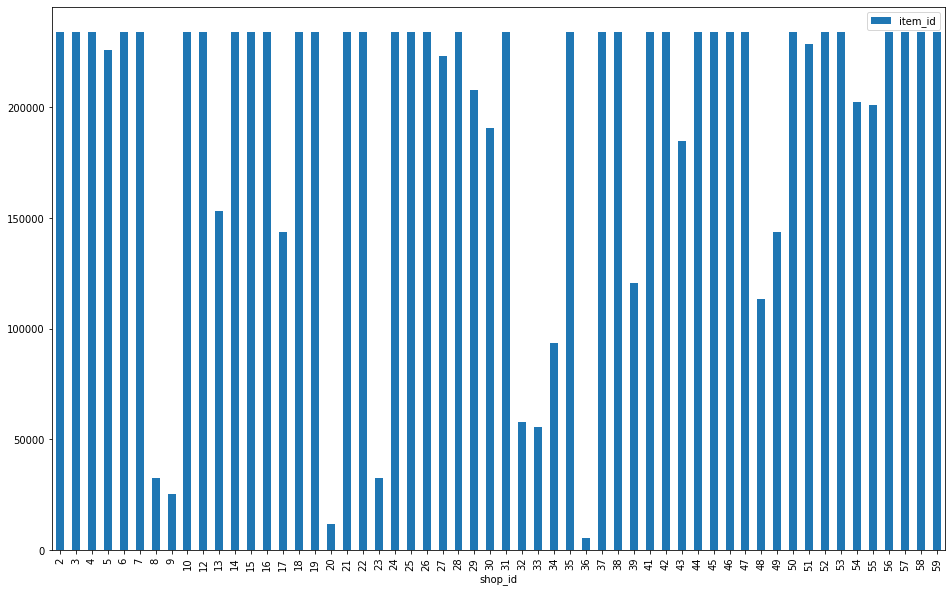

In [28]:
sales_train2.groupby('shop_id').agg({'item_id': 'count'}).plot.bar(figsize=(16, 10))

# Add calendar features

In [29]:
sales_train2

,date_block_num,shop_id,item_id,item_cnt_month,item_price,date_block_of_last_sale,last_saled_months_ago,first_day,last_day
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2,27,1.0,2499.0,0.0,0.0,11.0,11.0
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10842118,33,59,22162,0.0,0.0,0.0,0.0,0.0,0.0
10842119,33,59,22163,0.0,0.0,0.0,0.0,0.0,0.0
10842120,33,59,22164,0.0,0.0,0.0,0.0,0.0,0.0
10842121,33,59,22166,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
import math
import calendar
import holidays
import datetime

date_blocks = pd.DataFrame(sales_train2.date_block_num.drop_duplicates())
date_blocks = date_blocks.append({'date_block_num': 34}, ignore_index=True)

def add_month(col):
    return int(divmod(col, 12)[1] + 1)

def add_year(col):
    return int(2013 + divmod(col+1, 12)[0])

def add_year_month(row):
    return f'{row.year}-{row.month}'

def add_season(col):
    if 0 < col <= 2 or col == 12:
        return 'winter'
    if 3 <= col < 6:
        return 'spring'
    if 6 <= col < 9:
        return 'summer'
    if 9 <= col < 12:
        return 'autumn'
    return np.nan

# get number of holidays + weekend in each month    
ru_holidays = []

for date, name in sorted(holidays.RU(years=[2013, 2014, 2015]).items()):
    ru_holidays.append(date)
    
def add_holidays_and_weekends(row):
    busines_dates = pd.bdate_range(f"{row.year}-{row.month}-01", f"{row.year}-{row.month}-{row.days_in_month}")
    busines_dates = [b for b in busines_dates if b not in ru_holidays]
    return row.days_in_month - len(busines_dates)
    
def add_weeks_in_month(row):
    for i in range(1, row.days_in_month+1):
        d = datetime.datetime(row.year, row.month, i)
        if d.day > d.weekday():
            startdate = d
            break
    return ((datetime.datetime(row.year, row.month, row.days_in_month) - startdate).days) //7 + 1 
    
def create_calendar_features(data):
    data['month'] = data.date_block_num.apply(add_month).astype(np.int8) 
    data['year'] = data.date_block_num.apply(add_year).astype(np.int16) 
    data['year_month'] = data.apply(add_year_month, axis=1)
    data.year_month = pd.to_datetime(data.year_month, format='%Y-%m')
    data['days_in_month'] = data.year_month.dt.daysinmonth.astype(np.int8) 
    data['weeks_in_month'] = data.apply(add_weeks_in_month, axis=1).astype(np.int8) 
    data['season'] = data.month.apply(add_season)
    data['holidays_and_weekends_in_month'] = data.apply(add_holidays_and_weekends, axis=1)
    data.drop('year_month', axis=1, inplace=True)


create_calendar_features(date_blocks)
date_blocks.head()

,date_block_num,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month
0,0,1,2013,31,4,winter,14
1,1,2,2013,28,4,winter,8
2,2,3,2013,31,4,spring,11
3,3,4,2013,30,5,spring,8
4,4,5,2013,31,4,spring,10


# Add geographical features

In [31]:
def add_city(col):
    city = col.split(' ')
    if city[0][0] == '!':
        return city[0][1:]
    if city[0] == 'Адыгея':
        return 'Краснодар'
    return city[0]


def add_shop_type(col):
    if 'ТЦ' in col:
        return 1
    if 'ТРЦ' in col or 'МТРЦ' in col:
        return 2
    if 'ТК' in col:
        return 3
    if 'ТРК' in col:
        return 4
    for c in ['Якутск Орджоникидзе', 'Жуковский', 'Воронеж (Плехановская, 13)', 'Магазин С21']:
        if c in col:
            return 5
    return 0

# coordinates of cities and regions of Russia 
city_coords = dict()

city_coords['Балашиха'] = (55.797007, 37.938118, 1)       # Moscow area
city_coords['Волжский'] = (48.786127, 44.751229, 3)       # South
city_coords['Вологда'] = (59.220501, 39.891523, 2)        # North
city_coords['Воронеж'] = (51.660786, 39.200269, 3)        # South
city_coords['Выездная'] = (0, 0, 0)
city_coords['Жуковский'] = (55.597480, 38.119811, 1)      # Moscow area
city_coords['Интернет-магазин'] = (0, 0, 0)
city_coords['Казань'] = (55.796127, 49.106414, 4)         # East
city_coords['Калуга'] = (54.513845, 36.261224, 1)         # Moscow area
city_coords['Коломна'] = (55.103034, 38.752809, 1)        # Moscow area
city_coords['Краснодар'] = (45.035470, 38.975313, 3)      # South
city_coords['Красноярск'] = (56.010569, 92.852572, 5)     # Syberia
city_coords['Курск'] = (51.730846, 36.193015, 3)          # South
city_coords['Москва'] = (55.753220, 37.622513, 1)         # Moscow area
city_coords['Мытищи'] = (55.909665, 37.736132, 1)         # Moscow area
city_coords['Н.Новгород'] = (56.326797, 44.006516, 4)     # East
city_coords['Новосибирск'] = (55.030204, 82.920430, 5)    # Syberia
city_coords['Омск'] = (54.989347, 73.368221, 5)           # Syberia
city_coords['РостовНаДону'] = (47.222078, 39.720358, 3)   # South
city_coords['СПб'] = (59.938955, 30.315644, 2)            # North
city_coords['Самара'] = (53.195878, 50.100202, 4)         # East
city_coords['Сергиев'] = (56.315311, 38.135972, 1)        # Moscow area
city_coords['Сургут'] = (61.254035, 73.396230, 5)         # Syberia
city_coords['Томск'] = (56.484645, 84.947649, 5)          # Syberia
city_coords['Тюмень'] = (57.152985, 65.541227, 5)         # Syberia
city_coords['Уфа'] = (54.735152, 55.958736, 5)            # Syberia
city_coords['Химки'] = (55.888740, 37.430390, 1)          # Moscow area 
city_coords['Цифровой'] = (0, 0, 0)
city_coords['Чехов'] = (55.142350, 37.454357, 1)          # Moscow area
city_coords['Якутск'] = (62.027221, 129.732178, 4)        # Syberia
city_coords['Ярославль'] = (57.626559, 39.893813, 2)      # North

# districts of Moscow
moscow_dist = dict()

moscow_dist[20] = 0
moscow_dist['Москва "Распродажа"'] = 0                   # Center
moscow_dist['Балашиха ТРК "Октябрь-Киномир"'] = 2        # East
moscow_dist['Москва МТРЦ "Афи Молл"'] = 1                # Center
moscow_dist['Москва Магазин С21'] = 1                    # Center
moscow_dist['Москва ТК "Буденовский" (пав.А2)'] = 2      # East
moscow_dist['Москва ТК "Буденовский" (пав.К7)'] = 2      # East
moscow_dist['Москва ТРК "Атриум"'] = 1                   # Center
moscow_dist['Москва ТЦ "Ареал" (Беляево)'] = 3           # South
moscow_dist['Москва ТЦ "МЕГА Белая Дача II"'] = 2        # East
moscow_dist['Москва ТЦ "МЕГА Теплый Стан" II'] = 3       # South
moscow_dist['Москва ТЦ "Новый век" (Новокосино)'] = 2    # East
moscow_dist['Москва ТЦ "Перловский"'] = 4                # North
moscow_dist['Москва ТЦ "Семеновский"'] = 1               # Center
moscow_dist['Москва ТЦ "Серебряный Дом"'] = 1            # Center
moscow_dist['Мытищи ТРК "XL-3"'] = 4                     # North
moscow_dist['Химки ТЦ "Мега"'] = 4                       # North



shops['city'] = shops.shop_name.apply(add_city)

shops['city_lat'] = shops.city.map(lambda x: city_coords[x][0]) 
shops['city_lon'] = shops.city.map(lambda x: city_coords[x][1]) 
shops['region'] = shops.city.map(lambda x: city_coords[x][2]) 

shops['moscow_district'] = 0
shops['moscow_district'] = shops['moscow_district'].astype(np.int8)

shops.loc[shops.city.isin(['Балашиха',
                           'Москва', 
                           'Мытищи', 
                           'Химки']), 
          'moscow_district'] = shops.loc[shops.city.isin(['Балашиха', 
                                                          'Москва', 
                                                          'Мытищи', 
                                                          'Химки']), 
                                         'shop_name'].map(moscow_dist)

shops['shop_type'] = shops.shop_name.apply(add_shop_type)
shops.shop_type = shops.shop_type.astype(np.int8)

shops.head()

,shop_name,shop_id,city,city_lat,city_lon,region,moscow_district,shop_type
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск,62.027221,129.732178,4,0,5
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск,62.027221,129.732178,4,0,1
2,"Адыгея ТЦ ""Мега""",2,Краснодар,45.035470,38.975313,3,0,1
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,55.797007,37.938118,1,2,4
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,48.786127,44.751229,3,0,1


# Add expert features for items and shops

In [32]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [33]:
def add_global_category(col):
    cat = col.split(' ')
    if cat[0] == 'Игровые':
        return 'Игровые консоли'
    if cat[0] == 'Карты':
        return 'Карты оплаты'
    if cat[0] == 'Чистые':
        return 'Чистые носители'
    if cat[0] == 'Элементы':
        return 'Элементы питания'
    if cat[0] == 'Доставка':
        return 'Доставка товара'
    return cat[0]

def add_platform(col):
    platform_list = ['PS', 'XBOX', 'PC', 'Android', 'MAC', 'Windows', '1С', 'Blu-Ray',
                    'CD', 'DVD', 'MP3']
    for platform in platform_list:
        if platform in col:
            return platform
    return 'None'

def add_digital(col):
    if 'Цифра' in col:
        return 1
    return 0

def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)

item_categories['global_category'] = item_categories.item_category_name.apply(add_global_category)
item_categories['platform'] = item_categories.item_category_name.apply(add_platform)
# item_categories['is_digital'] = item_categories.item_category_name.apply(add_digital)

item_categories.head()

,item_category_name,item_category_id,global_category,platform
0,PC - Гарнитуры/Наушники,0,PC,PC
1,Аксессуары - PS2,1,Аксессуары,PS
2,Аксессуары - PS3,2,Аксессуары,PS
3,Аксессуары - PS4,3,Аксессуары,PS
4,Аксессуары - PSP,4,Аксессуары,PS


# Add data from other datasets to train and test datasets

Train dataset

In [34]:
sales_train2 = sales_train2.join(items.set_index('item_id'), on='item_id')
sales_train2 = sales_train2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_train2 = sales_train2.join(shops.set_index('shop_id'), on='shop_id')
sales_train2 = sales_train2.join(date_blocks.set_index('date_block_num'), on='date_block_num')

sales_train2.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price,date_block_of_last_sale,last_saled_months_ago,first_day,last_day,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,platform,shop_name,city,city_lat,city_lon,region,moscow_district,shop_type,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month
0,0,2,19,0.0,0.0,0.0,0.0,0.0,0.0,/ЗОЛОТАЯ КОЛЛЕКЦИЯ м/ф-72,40,22,25,Кино - DVD,Кино,DVD,"Адыгея ТЦ ""Мега""",Краснодар,45.03547,38.975313,3,0,1,1,2013,31,4,winter,14
1,0,2,27,1.0,2499.0,0.0,0.0,11.0,11.0,"007 Legends [PS3, русская версия]",19,30,33,Игры - PS3,Игры,PS,"Адыгея ТЦ ""Мега""",Краснодар,45.03547,38.975313,3,0,1,1,2013,31,4,winter,14
2,0,2,28,0.0,0.0,0.0,0.0,0.0,0.0,"007 Legends [PС, Jewel, русская версия]",30,35,39,Игры PC - Стандартные издания,Игры,PC,"Адыгея ТЦ ""Мега""",Краснодар,45.03547,38.975313,3,0,1,1,2013,31,4,winter,14
3,0,2,29,0.0,0.0,0.0,0.0,0.0,0.0,"007 Legends [Xbox 360, русская версия]",23,35,38,Игры - XBOX 360,Игры,XBOX,"Адыгея ТЦ ""Мега""",Краснодар,45.03547,38.975313,3,0,1,1,2013,31,4,winter,14
4,0,2,32,0.0,0.0,0.0,0.0,0.0,0.0,1+1,40,2,3,Кино - DVD,Кино,DVD,"Адыгея ТЦ ""Мега""",Краснодар,45.03547,38.975313,3,0,1,1,2013,31,4,winter,14


Test dataset

In [35]:
sales_test2 = sales_test2.join(items.set_index('item_id'), on='item_id')
sales_test2 = sales_test2.join(item_categories.set_index('item_category_id'), on='item_category_id')
sales_test2 = sales_test2.join(shops.set_index('shop_id'), on='shop_id')
sales_test2['date_block_num'] = 34
sales_test2 = sales_test2.join(date_blocks.set_index('date_block_num'), on='date_block_num')

sales_test2.head()

,shop_id,item_id,date_block_num,date_block_of_last_sale,last_saled_months_ago,first_day,last_day,item_name,item_category_id,item_name_cleaned_length,item_name_length,item_category_name,global_category,platform,shop_name,city,city_lat,city_lon,region,moscow_district,shop_type,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month
0,5,5037,34,32.0,2.0,0.0,0.0,"NHL 15 [PS3, русские субтитры]",19,27,30,Игры - PS3,Игры,PS,"Вологда ТРЦ ""Мармелад""",Вологда,59.220501,39.891523,2,0,2,11,2015,30,5,autumn,10
1,5,5320,34,0.0,0.0,0.0,0.0,ONE DIRECTION Made In The A.M.,55,28,31,Музыка - CD локального производства,Музыка,CD,"Вологда ТРЦ ""Мармелад""",Вологда,59.220501,39.891523,2,0,2,11,2015,30,5,autumn,10
2,5,5233,34,33.0,1.0,8.0,8.0,"Need for Speed Rivals (Essentials) [PS3, русск...",19,51,56,Игры - PS3,Игры,PS,"Вологда ТРЦ ""Мармелад""",Вологда,59.220501,39.891523,2,0,2,11,2015,30,5,autumn,10
3,5,5232,34,31.0,3.0,0.0,0.0,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,54,59,Игры - XBOX 360,Игры,XBOX,"Вологда ТРЦ ""Мармелад""",Вологда,59.220501,39.891523,2,0,2,11,2015,30,5,autumn,10
4,5,5268,34,0.0,0.0,0.0,0.0,"Need for Speed [PS4, русская версия]",20,33,36,Игры - PS4,Игры,PS,"Вологда ТРЦ ""Мармелад""",Вологда,59.220501,39.891523,2,0,2,11,2015,30,5,autumn,10


# Create mean encoded features

In [37]:
%%time

def create_gr_feats(data):
    # create aggregation feats for numeric features based on categorical ones
    for cat_col in ['shop_id', 'item_category_id', 'item_id']: # 'city', 'global_category'
        # create_col_with_min_freq(data, cat_col, 15,)
        data['sum_' + 'item_cnt_month' + 
             '_by_' + cat_col] = sales_train2.groupby(['date_block_num', 
                                                       cat_col])['item_cnt_month'].transform(np.sum).astype(np.float32)
        data['mean_' + 'item_price' + 
             '_by_' + cat_col] = sales_train2.groupby(['date_block_num', 
                                                       cat_col])['item_price'].transform(np.mean).astype(np.float32)

create_gr_feats(sales_train2)
create_gr_feats(sales_test2)

CPU times: user 3.66 s, sys: 772 ms, total: 4.43 s
Wall time: 4.43 s


# Add item_price features

In [ ]:
# %%time

# def add_int_part(col):
#     if np.isnan(col):
#         return np.nan
#     return divmod(col, 100)[0]

# def add_fract_part(col):
#     if np.isnan(col):
#         return np.nan
#     return divmod(col, 100)[1]

# def create_price_features(data):
#     data['price_int'] = data.item_price.apply(add_int_part) 
#     data['price_fract'] = data.item_price.apply(add_fract_part) 

# create_price_features(sales_train2)
# create_price_features(sales_test2)   

# sales_train2.head()

# Add lagged mean encoded features

In [38]:
%%time

index_cols = ['date_block_num', 'shop_id', 'item_id']

target_cols = [c for c in sales_train2.columns if c.startswith('sum_item_cnt', 0, 13)] + ['item_cnt_month']
price_cols = [c for c in sales_train2.columns if c.startswith('mean_item_price', 0, 15)]

def create_time_features():
    global sales_train2, sales_test2
    win = [1, 2, 3, 4, 5, 12]
    for w in tqdm_notebook(win):
        cols = target_cols
        
        tmp = sales_train2[index_cols + cols].copy()
        
        tmp.date_block_num = tmp.date_block_num + w
        
        foo = lambda x: f'{x}_lag_{w}' if x in cols else x
        tmp.rename(columns=foo, inplace=True)

        sales_train2 = sales_train2.join(tmp.set_index(index_cols), on=index_cols)
        sales_test2 = sales_test2.join(tmp.set_index(index_cols), on=index_cols)
        
        del tmp
        gc.collect()

# drop all mean encoded columns, except item_cnt_month
create_time_features()

target_cols.remove('item_cnt_month')
sales_train2.drop(target_cols+price_cols, axis=1, inplace=True)
sales_test2.drop(target_cols+price_cols, axis=1, inplace=True)

  0%|          | 0/6 [00:00<?, ?it/s]

CPU times: user 43.5 s, sys: 13.9 s, total: 57.5 s
Wall time: 56.5 s


# Add number of sales for closest item IDs

In [39]:
%%time

index_cols = ['date_block_num', 'shop_id', 'item_id']

def add_closest_ids(win):
    global sales_train2, sales_test2

    target_cols = [f'item_cnt_month_lag_{w}' for w in win]
    
    # add previous sales of items from the same group with next id
    tmp = sales_train2[index_cols + target_cols].copy()

    tmp.item_id = tmp.item_id + 1

    foo = lambda x: f'{x}_prev_id' if x in target_cols else x
    tmp.rename(columns=foo, inplace=True)

    sales_train2 = sales_train2.join(tmp.set_index(index_cols), on=index_cols)
    sales_test2 = sales_test2.join(tmp.set_index(index_cols), on=index_cols)
    
    del tmp
    gc.collect()
    
    # add previous sales of items from the same group with previous id
    tmp = sales_train2[index_cols + target_cols].copy()
    
    tmp.item_id = tmp.item_id - 1

    foo = lambda x: f'{x}_next_id' if x in target_cols else x
    tmp.rename(columns=foo, inplace=True)

    sales_train2 = sales_train2.join(tmp.set_index(index_cols), on=index_cols)
    sales_test2 = sales_test2.join(tmp.set_index(index_cols), on=index_cols)

    del tmp
    gc.collect()

# drop all mean encoded columns, except item_cnt_month
add_closest_ids([1, 2, 3])

CPU times: user 13.2 s, sys: 3.83 s, total: 17.1 s
Wall time: 16.7 s


# Downcast dataset

In [40]:
sales_train2 = downcast_dtypes(sales_train2)
sales_test2 = downcast_dtypes(sales_test2)

# Add mean lagged revenue by shop, item_id and item_category

In [ ]:
# lagged_counts = [c for c in sales_train2.columns if c.startswith('mean_item_cnt_month', 0, 19)] 
# lagged_prices = [c for c in sales_train2.columns if c.startswith('mean_item_price', 0, 15)]

# for i in range(len(lagged_counts)):
#     suffix = lagged_counts[i][len('mean_item_cnt_month'):]
#     sales_train2[f'mean_revenue{suffix}'] = sales_train2[lagged_counts[i]]*sales_train2[lagged_prices[i]]
#     sales_test2[f'mean_revenue{suffix}'] = sales_train2[lagged_counts[i]]*sales_train2[lagged_prices[i]]

# Drop unnecessary columns and rows

In [41]:
# drop rows with shop id 20 (small size and aren't presented in the test set)
sales_train2 = sales_train2[(sales_train2.shop_id != 20)]

# Don't use old data from year 2013
sales_train2 = sales_train2[sales_train2['date_block_num'] >= 12] 

sales_train2.drop(['shop_name','item_name', 'item_price', 'item_category_name'], axis=1, inplace=True)
sales_test2.drop(['shop_name', 'item_name', 'item_category_name'], axis=1, inplace=True)

# Add time statistics (mean, mode, min, max, std, EWM, difference, etc.)

In [42]:
%%time

def add_time_statistics(data):
    for win in tqdm_notebook([2, 3, 5]):
        cols = get_window(data, win)
        tmp = data[cols]
        
        data[f'{win}_month_mean_cnt'] = tmp.mean(axis=1).astype(np.float32)
        data[f'{win}_month_median_cnt'] = tmp.median(axis=1).astype(np.float32)
        data[f'{win}_month_min_cnt'] = np.nanmin(tmp, axis=1).astype(np.float32)
        data[f'{win}_month_max_cnt'] = np.nanmax(tmp, axis=1).astype(np.float32)
        data[f'{win}_month_std_cnt'] = tmp.std(axis=1).astype(np.float32)

        # add exponential weighted mean (EWM)
        data[f'mean_ewm_prev_{win}'] = tmp.T.ewm(com=9.5).mean().T.mean(axis=1).astype(np.float32)
        data[f'last_ewm_prev_{win}'] = tmp.T.ewm(com=9.5).mean().T.iloc[:,-1].astype(np.float32)

        # add difference between data points
#         data[f'avg_diff_{win}'] = (tmp - tmp.shift(1, axis=1)).mean(axis=1).astype(np.float32)
        
            
def get_window(data, w):
    cols = []
    col_num = 1
    for i in data.columns:
        if col_num > w:
            break
        if i == f'item_cnt_month_lag_{col_num}':
            cols.append(i)
            col_num += 1
    return cols

add_time_statistics(sales_train2)
add_time_statistics(sales_test2)

  0%|          | 0/3 [00:00<?, ?it/s]

<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered
<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered
<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered


  0%|          | 0/3 [00:00<?, ?it/s]

<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered
<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered
<timed exec>:8: RuntimeWarning: All-NaN axis encountered
<timed exec>:9: RuntimeWarning: All-NaN axis encountered


CPU times: user 3min 17s, sys: 1.44 s, total: 3min 19s
Wall time: 3min 19s


# Encode text features with label encoder.

In [44]:
sales_train2.shape

(6341620, 76)

In [45]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

cols = ['city', 'platform', 'season', 'global_category']
sales_train2[cols] = sales_train2[cols].apply(LabelEncoder().fit_transform)
sales_test2[cols] = sales_test2[cols].apply(LabelEncoder().fit_transform)

Save data to files

In [ ]:
# sales_train2.to_hdf('sales_train2', key='df')
# sales_test2.to_hdf('sales_test2', key='df')

In [46]:
sales_train2.head()

,date_block_num,shop_id,item_id,item_cnt_month,date_block_of_last_sale,last_saled_months_ago,first_day,last_day,item_category_id,item_name_cleaned_length,item_name_length,global_category,platform,city,city_lat,city_lon,region,moscow_district,shop_type,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,item_cnt_month_lag_1,sum_item_cnt_month_by_shop_id_lag_2,sum_item_cnt_month_by_item_category_id_lag_2,sum_item_cnt_month_by_item_id_lag_2,item_cnt_month_lag_2,sum_item_cnt_month_by_shop_id_lag_3,sum_item_cnt_month_by_item_category_id_lag_3,sum_item_cnt_month_by_item_id_lag_3,item_cnt_month_lag_3,sum_item_cnt_month_by_shop_id_lag_4,sum_item_cnt_month_by_item_category_id_lag_4,sum_item_cnt_month_by_item_id_lag_4,item_cnt_month_lag_4,sum_item_cnt_month_by_shop_id_lag_5,sum_item_cnt_month_by_item_category_id_lag_5,sum_item_cnt_month_by_item_id_lag_5,item_cnt_month_lag_5,sum_item_cnt_month_by_shop_id_lag_12,sum_item_cnt_month_by_item_category_id_lag_12,sum_item_cnt_month_by_item_id_lag_12,item_cnt_month_lag_12,item_cnt_month_lag_1_prev_id,item_cnt_month_lag_2_prev_id,item_cnt_month_lag_3_prev_id,item_cnt_month_lag_1_next_id,item_cnt_month_lag_2_next_id,item_cnt_month_lag_3_next_id,2_month_mean_cnt,2_month_median_cnt,2_month_min_cnt,2_month_max_cnt,2_month_std_cnt,mean_ewm_prev_2,last_ewm_prev_2,3_month_mean_cnt,3_month_median_cnt,3_month_min_cnt,3_month_max_cnt,3_month_std_cnt,mean_ewm_prev_3,last_ewm_prev_3,5_month_mean_cnt,5_month_median_cnt,5_month_min_cnt,5_month_max_cnt,5_month_std_cnt,mean_ewm_prev_5,last_ewm_prev_5
4488756,12,2,27,0.0,0.0,0.0,0.0,0.0,19,30,33,4,9,10,45.035469,38.975311,3,0,1,1,2014,31,4,3,14,1322.0,15818.0,4.0,0.0,862.0,9030.0,2.0,0.0,795.0,14113.0,6.0,0.0,945.0,18932.0,1.0,0.0,875.0,10488.0,1.0,0.0,1146.0,8983.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4488757,12,2,30,0.0,0.0,0.0,0.0,0.0,40,23,26,6,4,10,45.035469,38.975311,3,0,1,1,2014,31,4,3,14,1322.0,28598.0,47.0,0.0,862.0,25433.0,46.0,0.0,795.0,24173.0,24.0,0.0,945.0,23348.0,13.0,0.0,875.0,24130.0,19.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4488758,12,2,31,0.0,0.0,0.0,0.0,0.0,37,26,31,6,2,10,45.035469,38.975311,3,0,1,1,2014,31,4,3,14,1322.0,9959.0,25.0,0.0,862.0,7420.0,27.0,0.0,795.0,6950.0,25.0,0.0,945.0,7659.0,19.0,0.0,875.0,8680.0,25.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4488759,12,2,32,1.0,0.0,0.0,13.0,13.0,40,2,3,6,4,10,45.035469,38.975311,3,0,1,1,2014,31,4,3,14,1322.0,28598.0,89.0,0.0,862.0,25433.0,81.0,0.0,795.0,24173.0,58.0,0.0,945.0,23348.0,59.0,0.0,875.0,24130.0,72.0,0.0,1146.0,33488.0,299.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4488760,12,2,33,1.0,11.0,1.0,29.0,29.0,37,5,8,6,2,10,45.035469,38.975311,3,0,1,1,2014,31,4,3,14,1322.0,9959.0,42.0,1.0,862.0,7420.0,15.0,2.0,795.0,6950.0,33.0,0.0,945.0,7659.0,43.0,0.0,875.0,8680.0,35.0,0.0,1146.0,6094.0,61.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,1.5,1.0,2.0,0.707107,1.2625,1.525,1.0,1.0,0.0,2.0,1.0,1.163343,0.965029,0.6,0.0,0.0,2.0,0.894427,0.939373,0.520396


In [47]:
sales_test2.head()

,shop_id,item_id,date_block_num,date_block_of_last_sale,last_saled_months_ago,first_day,last_day,item_category_id,item_name_cleaned_length,item_name_length,global_category,platform,city,city_lat,city_lon,region,moscow_district,shop_type,month,year,days_in_month,weeks_in_month,season,holidays_and_weekends_in_month,sum_item_cnt_month_by_shop_id_lag_1,sum_item_cnt_month_by_item_category_id_lag_1,sum_item_cnt_month_by_item_id_lag_1,item_cnt_month_lag_1,sum_item_cnt_month_by_shop_id_lag_2,sum_item_cnt_month_by_item_category_id_lag_2,sum_item_cnt_month_by_item_id_lag_2,item_cnt_month_lag_2,sum_item_cnt_month_by_shop_id_lag_3,sum_item_cnt_month_by_item_category_id_lag_3,sum_item_cnt_month_by_item_id_lag_3,item_cnt_month_lag_3,sum_item_cnt_month_by_shop_id_lag_4,sum_item_cnt_month_by_item_category_id_lag_4,sum_item_cnt_month_by_item_id_lag_4,item_cnt_month_lag_4,sum_item_cnt_month_by_shop_id_lag_5,sum_item_cnt_month_by_item_category_id_lag_5,sum_item_cnt_month_by_item_id_lag_5,item_cnt_month_lag_5,sum_item_cnt_month_by_shop_id_lag_12,sum_item_cnt_month_by_item_category_id_lag_12,sum_item_cnt_month_by_item_id_lag_12,item_cnt_month_lag_12,item_cnt_month_lag_1_prev_id,item_cnt_month_lag_2_prev_id,item_cnt_month_lag_3_prev_id,item_cnt_month_lag_1_next_id,item_cnt_month_lag_2_next_id,item_cnt_month_lag_3_next_id,2_month_mean_cnt,2_month_median_cnt,2_month_min_cnt,2_month_max_cnt,2_month_std_cnt,mean_ewm_prev_2,last_ewm_prev_2,3_month_mean_cnt,3_month_median_cnt,3_month_min_cnt,3_month_max_cnt,3_month_std_cnt,mean_ewm_prev_3,last_ewm_prev_3,5_month_mean_cnt,5_month_median_cnt,5_month_min_cnt,5_month_max_cnt,5_month_std_cnt,mean_ewm_prev_5,last_ewm_prev_5
0,5,5037,34,32.0,2.0,0.0,0.0,19,27,30,4,9,2,59.220501,39.891521,2,0,2,11,2015,30,5,0,10,1052.0,2443.0,25.0,0.0,1092.0,3979.0,110.0,1.0,1294.0,4667.0,119.0,3.0,991.0,3178.0,54.0,1.0,954.0,3487.0,105.0,1.0,1445.0,6134.0,65.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0.5,0.5,0.0,1.0,0.707107,0.2625,0.525,1.333333,1.0,0.0,3.0,1.527525,0.652935,1.433805,1.200000,1.0,0.0,3.0,1.095445,0.900262,1.233931
1,5,5320,34,0.0,0.0,0.0,0.0,55,28,31,8,3,2,59.220501,39.891521,2,0,2,11,2015,30,5,0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5,5233,34,33.0,1.0,8.0,8.0,19,51,56,4,9,2,59.220501,39.891521,2,0,2,11,2015,30,5,0,10,1052.0,2443.0,42.0,1.0,1092.0,3979.0,80.0,3.0,1294.0,4667.0,150.0,1.0,991.0,3178.0,37.0,0.0,954.0,3487.0,119.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,2.0,1.0,3.0,1.414214,1.5250,2.050,1.666667,1.0,1.0,3.0,1.154701,1.571482,1.664446,1.400000,1.0,0.0,3.0,1.140175,1.455947,1.381343
3,5,5232,34,31.0,3.0,0.0,0.0,23,54,59,4,11,2,59.220501,39.891521,2,0,2,11,2015,30,5,0,10,1052.0,2203.0,28.0,0.0,1092.0,3590.0,48.0,0.0,1294.0,3650.0,65.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,0.0000,0.000,0.333333,0.0,0.0,1.0,0.577350,0.122398,0.367194,0.333333,0.0,0.0,1.0,0.577350,0.220316,0.367194
4,5,5268,34,0.0,0.0,0.0,0.0,20,33,36,4,9,2,59.220501,39.891521,2,0,2,11,2015,30,5,0,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Clip train target value

In [48]:
sales_train2.item_cnt_month.clip(0, 20, inplace=True)

sales_train2.fillna(0, inplace=True)
sales_test2.fillna(0, inplace=True)

# Train model

Split datasets by train and validation parts

In [ ]:
# sales_train2.to_hdf('sales_train2', key='df')
# sales_test2.to_hdf('sales_test2', key='df')

In [55]:
train_index = sales_train2[(sales_train2.date_block_num < 33)].index
valid_index = sales_train2[sales_train2.date_block_num == 33].index

# cols = [col for col in sales_train2.columns if col not in ['item_id', 'shop_id', 
#                                                            'date_block_num', 'item_cnt_month']]
cols = [col for col in sales_train2.columns if col not in ['item_cnt_month', 'first_day', 'last_day']]

x = sales_train2[cols]
y = sales_train2['item_cnt_month']

X_train, X_valid = x.loc[train_index], x.loc[valid_index]

# del x
# gc.collect()

y_train, y_valid = y.loc[train_index], y.loc[valid_index]

Train LGBM

In [57]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

mean_score = []

feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 32,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
#     'min_data_in_leaf': 5,
#     'lambda_l1': 0.1,
#     'lambda_l2': 0.1,
    'bagging_freq': 5,
    'verbose': 1
}
cat_feats = ['shop_id',
             'item_category_id',
             'city',
             'global_category', 
             'platform',
             'season']

lgb_train = lgb.Dataset(X_train[feature_name], y_train)
# lgb_train = lgb.Dataset(x[feature_name], y)

lgb_eval = lgb.Dataset(X_valid[feature_name], y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train,
        num_boost_round=1000,
        valid_sets=(lgb_train, lgb_eval), 
#         valid_sets=lgb_train,
        feature_name = feature_name,
        categorical_feature = cat_feats,
        verbose_eval=50, 
        evals_result = evals_result,
        early_stopping_rounds = 30)

Training until validation scores don't improve for 30 rounds
[50]	training's rmse: 1.05656	valid_1's rmse: 0.993595
[100]	training's rmse: 0.96084	valid_1's rmse: 0.918
[150]	training's rmse: 0.893489	valid_1's rmse: 0.8672
[200]	training's rmse: 0.847969	valid_1's rmse: 0.835203
[250]	training's rmse: 0.81633	valid_1's rmse: 0.814677
[300]	training's rmse: 0.794387	valid_1's rmse: 0.801451
[350]	training's rmse: 0.77924	valid_1's rmse: 0.793959
[400]	training's rmse: 0.768754	valid_1's rmse: 0.788539
[450]	training's rmse: 0.76118	valid_1's rmse: 0.784493
[500]	training's rmse: 0.755371	valid_1's rmse: 0.781245
[550]	training's rmse: 0.750627	valid_1's rmse: 0.778913
[600]	training's rmse: 0.746573	valid_1's rmse: 0.777579
[650]	training's rmse: 0.743037	valid_1's rmse: 0.7762
[700]	training's rmse: 0.740264	valid_1's rmse: 0.774499
[750]	training's rmse: 0.737675	valid_1's rmse: 0.773666
[800]	training's rmse: 0.735006	valid_1's rmse: 0.773591
Early stopping, best iteration is:
[774]

Feature importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

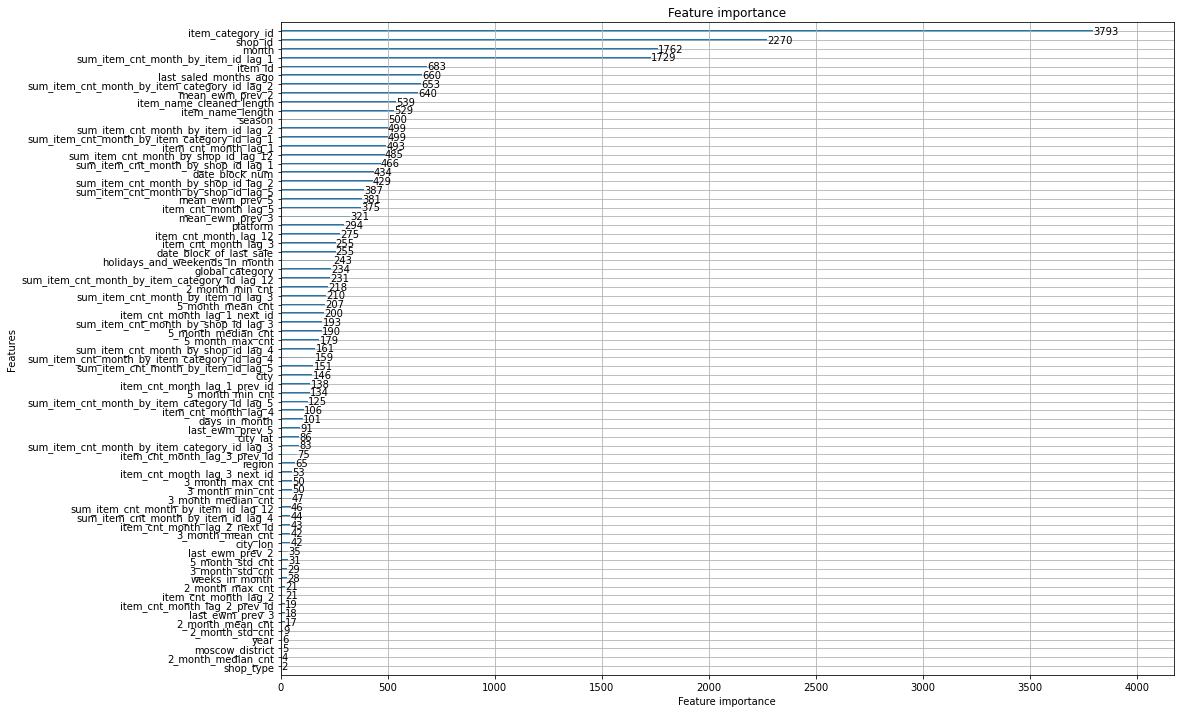

In [58]:
lgb.plot_importance(gbm, figsize=(16, 12))

Model learning curve

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='rmse'>

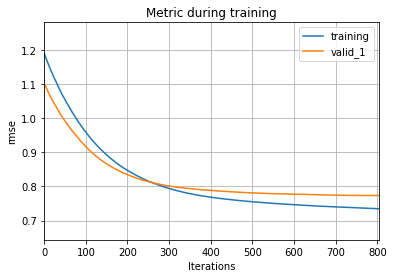

In [59]:
lgb.plot_metric(evals_result)

# Make prediction

In [60]:
y = gbm.predict(sales_test2[cols])

null_ind = sales_test.loc[~sales_test.item_id.isin(sales_train.item_id.unique())].index

submission['item_cnt_month'] = y
submission.item_cnt_month.clip(0, 20, inplace=True)

submission.head(10)

,ID,item_cnt_month
0,0,1.343925
1,1,0.197621
2,2,1.557018
3,3,1.231060
4,4,2.907686
5,5,1.240856
6,6,1.641635
7,7,1.100200
8,8,1.543431
9,9,0.188500


# Save to file

In [61]:
submission.to_csv('submission.csv', index=False)

# Futher ideas

- optimize hyperparameters with Optuna

- add average sales per day

- add text description



- drop date_block_num, shop_id and item_id

- try AutoML

- split dataset according to the most important feature(s)

- are item_id, shop_id have to be categorical values?